## File Process to Extract Data

In [2]:
import h5py
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [6]:
def create_X_for_onerec(filename):
    
    dataset_on = h5py.File(filename+'_on.hdf5', 'r')
    dataset_off = h5py.File(filename+'_off.hdf5', 'r')
    
    # number of non-zero elements
    length = np.nonzero(dataset_on['timestamp'][:])[0][-1] + 1

    X_train_DVS, X_train_gray, X_test_DVS, X_test_gray, Y_train, Y_test = None, None, None, None, None, None
    X_DVS = np.zeros((1,260,346,2))
    X_gray = np.zeros((1,260,346))
    Y = np.zeros((1,))
    
    #num_frames = 2000 if length > 2000 else length
    #for i in range(num_frames):
    num_train = 0
    num_test = 0
    for i in range(2000, length):
        if num_train == 1300 and num_test == 800:
            break
        
        X_DVS[0,:,:,0] = dataset_on['dvs_frame'][i]
        X_DVS[0,:,:,1] = dataset_off['dvs_frame'][i]
        X_gray[0,:,:] = dataset_on['aps_frame'][i]
        Y[0] = dataset_on['steering_wheel_angle'][i]
        n = int(i/1200)
        if ((i - 1200*n) < 800) and (Y[0] > 5 or Y[0] < -5) and (num_train < 1300):
            X_train_DVS = np.concatenate((X_train_DVS, X_DVS), axis=0) if X_train_DVS is not None else X_DVS
            X_train_gray = np.concatenate((X_train_gray, X_gray), axis=0) if X_train_gray is not None else X_gray
            Y_train = np.concatenate((Y_train, Y), axis = 0) if Y_train is not None else Y
            num_train += 1
            
        elif ((i - 1200*n) >= 800) and (Y[0] > 5 or Y[0] < -5) and (num_test < 800):
            X_test_DVS = np.concatenate((X_test_DVS, X_DVS), axis=0) if X_test_DVS is not None else X_DVS
            X_test_gray = np.concatenate((X_test_gray, X_gray), axis=0) if X_test_gray is not None else X_gray
            Y_test = np.concatenate((Y_test, Y), axis = 0) if Y_test is not None else Y
            num_test += 1
            
        #print('processing the ' + str(i) +'th frame,' + str(num_frames) + ' frames in total')
        print('num_train: '+str(num_train)+'\t num_test: '+str(num_test)+'\t i: '+str(i)+'\t length: '+str(length))
        
        
    return X_train_DVS, X_train_gray, X_test_DVS, X_test_gray, Y_train, Y_test

In [7]:
filename = 'DDD17_night/rec1487354030'

In [8]:
X_train_DVS, X_train_gray, X_test_DVS, X_test_gray, Y_train, Y_test = create_X_for_onerec(filename)

num_train: 0	 num_test: 0	 i: 2000	 length: 7560
num_train: 0	 num_test: 0	 i: 2001	 length: 7560
num_train: 0	 num_test: 0	 i: 2002	 length: 7560
num_train: 0	 num_test: 0	 i: 2003	 length: 7560
num_train: 0	 num_test: 0	 i: 2004	 length: 7560
num_train: 0	 num_test: 1	 i: 2005	 length: 7560
num_train: 0	 num_test: 2	 i: 2006	 length: 7560
num_train: 0	 num_test: 3	 i: 2007	 length: 7560
num_train: 0	 num_test: 4	 i: 2008	 length: 7560
num_train: 0	 num_test: 5	 i: 2009	 length: 7560
num_train: 0	 num_test: 6	 i: 2010	 length: 7560
num_train: 0	 num_test: 7	 i: 2011	 length: 7560
num_train: 0	 num_test: 8	 i: 2012	 length: 7560
num_train: 0	 num_test: 9	 i: 2013	 length: 7560
num_train: 0	 num_test: 10	 i: 2014	 length: 7560
num_train: 0	 num_test: 11	 i: 2015	 length: 7560
num_train: 0	 num_test: 12	 i: 2016	 length: 7560
num_train: 0	 num_test: 13	 i: 2017	 length: 7560
num_train: 0	 num_test: 14	 i: 2018	 length: 7560
num_train: 0	 num_test: 15	 i: 2019	 length: 7560
num_train: 0	 

In [11]:
# Save data
#---------------------------------------------
# run this cell only once
#---------------------------------------------

outfile = 'DDD17_night/X_DVS_new.hdf5'
hf = h5py.File(outfile, 'w')
hf.create_dataset('X_train_DVS', data=X_train_DVS)
hf.create_dataset('X_test_DVS', data=X_test_DVS)
hf.close()

outfile = 'DDD17_night/X_gray_new.hdf5'
hf = h5py.File(outfile, 'w')
hf.create_dataset('X_train_gray', data=X_train_gray)
hf.create_dataset('X_test_gray', data=X_test_gray)
hf.close()

outfile = 'DDD17_night/Y_new.hdf5'
hf = h5py.File(outfile, 'w')
hf.create_dataset('Y_train', data=Y_train)
hf.create_dataset('Y_test', data=Y_test)
hf.close()

## Data preprocessing

In [3]:
def plot_steering_angle(angle):
    a_rad = angle / 180. * np.pi + np.pi / 2
    c, r = (173, 130), 65 #center, radius
    t = (c[0] + int(np.cos(a_rad) * r), c[1] - int(np.sin(a_rad) * r))
    plt.plot((c[0], t[0]), (c[1], t[1]), 'r')
    plt.gca().add_artist(plt.Circle(c, r, edgecolor='r', facecolor='none'))
    plt.text(c[0]-35, c[1]+30, '{:0.1f} deg'.format(angle), color='r')

### Process old dataset and combine with new dataset

In [13]:
dataset = 'DDD17_night/'
hf = h5py.File(dataset + 'Y.hdf5', 'r')
Y_train = hf['Y_train'][:]
Y_test = hf['Y_test'][:]
indices_train = np.where((Y_train<=5)&(Y_train>=-5))[0]
indices_train = indices_train[:100]
Y_train = np.delete(Y_train, indices_train, axis = 0)
hf.close()
hf = h5py.File(dataset + 'Y_new.hdf5', 'r')
Y_train = np.concatenate((Y_train, hf['Y_train'][:]), axis = 0)
Y_test = np.concatenate((Y_test, hf['Y_test'][:]), axis = 0)
hf.close()
print(Y_train.shape+Y_test.shape)

hf = h5py.File(dataset + 'X_DVS.hdf5', 'r')
X_train_DVS = hf['X_train_DVS'][:]
X_test_DVS = hf['X_test_DVS'][:]
X_train_DVS = np.delete(X_train_DVS, indices_train, axis = 0)
hf.close()
hf = h5py.File(dataset + 'X_DVS_new.hdf5', 'r')
X_train_DVS = np.concatenate((X_train_DVS, hf['X_train_DVS'][:]), axis = 0)
X_test_DVS = np.concatenate((X_test_DVS, hf['X_test_DVS'][:]), axis = 0)
hf.close()
print(X_train_DVS.shape+X_test_DVS.shape)

hf = h5py.File(dataset + 'X_gray.hdf5', 'r')
X_train_gray = hf['X_train_gray'][:]
X_test_gray = hf['X_test_gray'][:]
X_train_gray = np.delete(X_train_gray, indices_train, axis = 0)
hf.close()
hf = h5py.File(dataset + 'X_gray_new.hdf5', 'r')
X_train_gray = np.concatenate((X_train_gray, hf['X_train_gray'][:]), axis = 0)
X_test_gray = np.concatenate((X_test_gray, hf['X_test_gray'][:]), axis = 0)
hf.close()
print(X_train_gray.shape+X_test_gray.shape)

(2800, 1168)
(2800, 260, 346, 2, 1168, 260, 346, 2)
(2800, 260, 346, 1168, 260, 346)


### Create final combined dataset

In [14]:
# Save final combined data
#---------------------------------------------
outfile = 'DDD17_night/data_final.hdf5'
hf = h5py.File(outfile, 'w')
hf.create_dataset('X_train_DVS', data=X_train_DVS)
hf.create_dataset('X_test_DVS', data=X_test_DVS)
hf.create_dataset('X_train_gray', data=X_train_gray)
hf.create_dataset('X_test_gray', data=X_test_gray)
hf.create_dataset('Y_train', data=Y_train)
hf.create_dataset('Y_test', data=Y_test)
#---------------------------------------------

<HDF5 dataset "Y_test": shape (1168,), type "<f8">

### Plot histogram

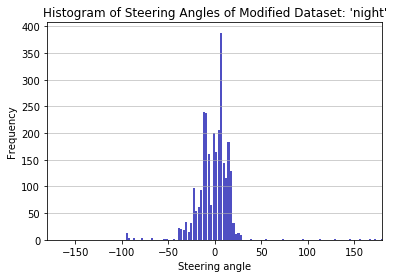

In [16]:
n, bins, patches = plt.hist(x=Y_train, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.title('Histogram of Steering Angles of Modified Dataset: \'night\'')
plt.xlabel('Steering angle')
plt.xlim([-180, 180])
plt.ylabel('Frequency')
plt.show()

In [9]:
num = 0
for index, item in enumerate(Y_test):
    if item >= -5 and item <= 5:
        num += 1
print(num)

100


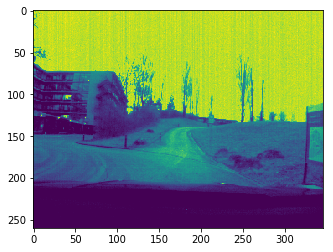

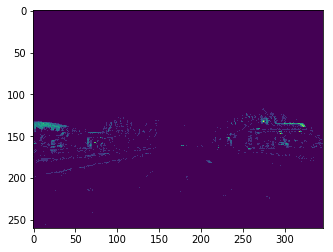

In [8]:
plt.imshow(X_train_gray[500])
plt.figure()
plt.imshow(X_train_DVS[499][:,:,1])
plt.show()

In [3]:
hf = h5py.File('DDD17_night/Y.hdf5')
# X_train_DVS = hf['X_train_DVS'][:]
# X_test_DVS = hf['X_test_DVS'][:]
# X_train_gray = hf['X_train_gray'][:]
# X_test_gray = hf['X_test_gray'][:]
Y_test = hf['Y_test'][:]
hf.close()
# print(X_train_DVS.shape)
# print(X_train_gray.shape)
# print(X_test_DVS.shape)
# print(X_test_gray.shape)
print(Y_test.shape)
# print(Y_test.shape)

(400,)


In [17]:
print(Y_train.shape)

(2800,)
